In [1]:
import numpy as np
import pandas as pd
import cv2
import glob as gb
import os
import matplotlib.pyplot as plt

In [2]:
def getcode(n):
    for x,y in code.items() :
        if n==y :
            return x


In [8]:
s=64
code={'anger':0,'contempt':1,'disgust':2,'fear':3,'happy':4,'sadness':5,'surprise':6}
X_train=[]
y_train=[]
train_dir='../input/ckplus/CK+48/'
for folder in os.listdir(train_dir):
    files=gb.glob(pathname=str(train_dir+folder+'/*.png'))
    for file in files :
        image=cv2.imread(file)
        X_train.append(list(cv2.resize(image,(s,s))))
        y_train.append(code[folder])

X_train=np.array(X_train)
y_train=np.array(y_train)

In [9]:
X_train=X_train/255.0

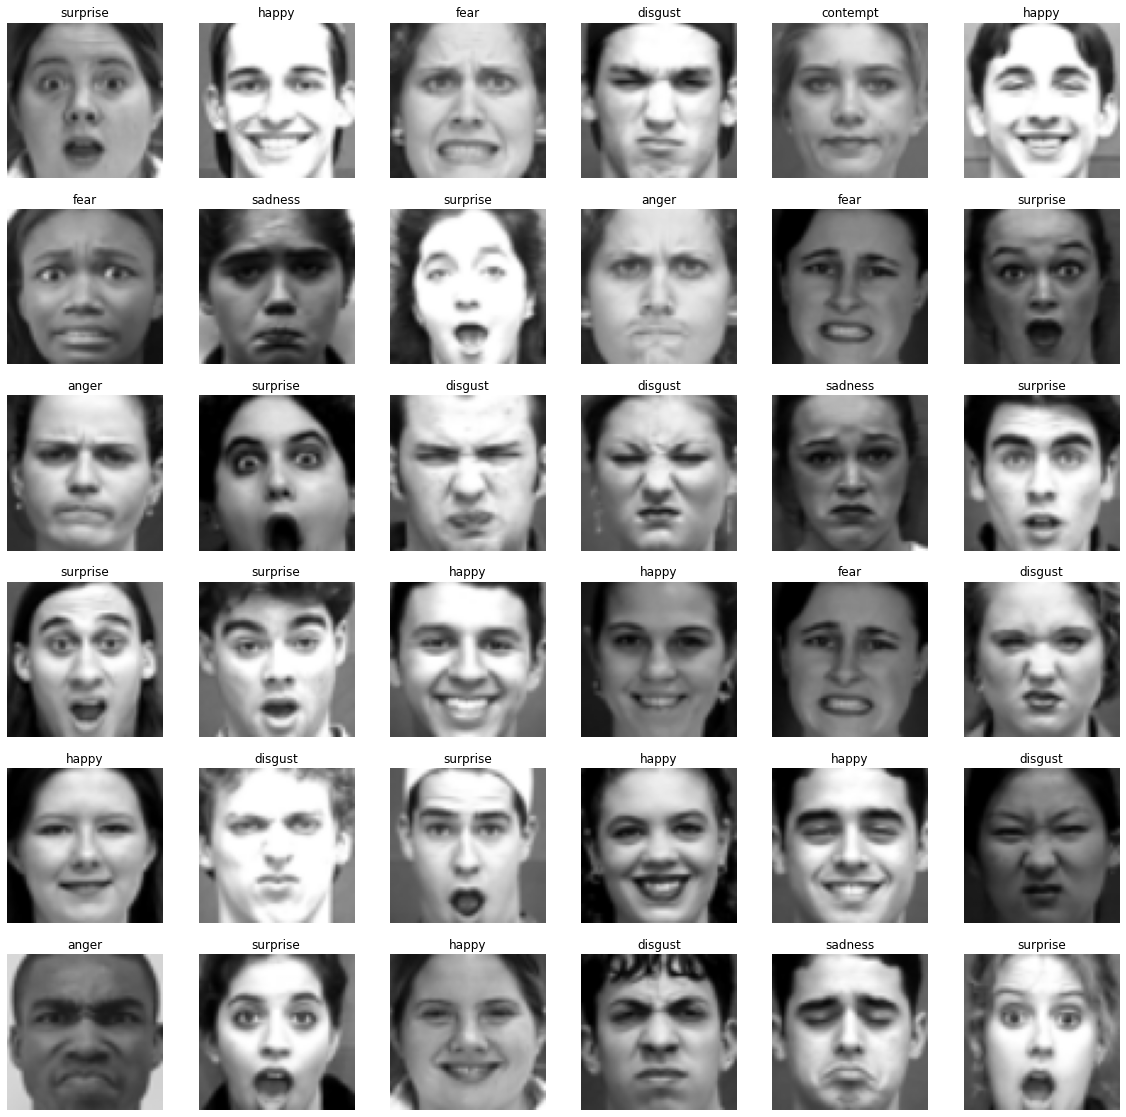

In [10]:
plt.figure(figsize=(20,20))
for n ,i in enumerate(list(np.random.randint(0,len(X_train),36))) :
    plt.subplot(6,6,n+1)
    plt.imshow(X_train[i])
    plt.axis('off')
    plt.title(getcode(y_train[i]))

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range = 40,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')

train_generator = train_datagen.flow(X_train,y_train,batch_size=8,shuffle=True)

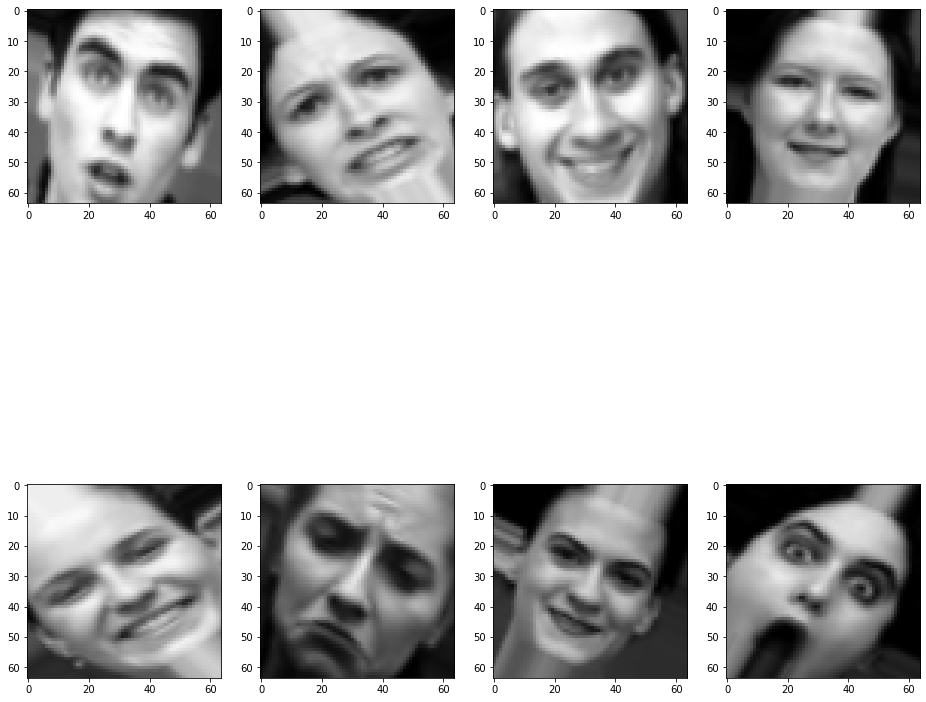

In [12]:
plt.figure(figsize=(16, 16))
for X_batch, y_batch in train_generator:
    # create a grid of 3x3 images
    for i in range(0, 8):
        plt.subplot(2,4,i+1)
        plt.imshow(X_batch[i])
    # show the plot
    plt.show()
    break

In [13]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("-------------------------------")

X_train shape:  (981, 64, 64, 3)
y_train shape:  (981,)
-------------------------------


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense ,Flatten ,Conv2D ,MaxPooling2D ,Dropout ,BatchNormalization
from tensorflow.keras.optimizers import Adam , RMSprop
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint



In [16]:
model=Sequential([
                  Conv2D(64,3,activation='relu',kernel_initializer='he_normal',input_shape=(64,64,3)),
                  MaxPooling2D(3),
                  Conv2D(128,3,activation='relu',kernel_initializer='he_normal'),
                  Conv2D(256,3,activation='relu',kernel_initializer='he_normal'),
                  MaxPooling2D(3),
                  Flatten(),
                  Dense(256,activation='relu'),
                  Dense(7,activation='softmax',kernel_initializer='glorot_normal')
                  
])


In [17]:
es = EarlyStopping(
    monitor='val_accuracy', min_delta=0.0001, patience=10, verbose=2,
    mode='max', baseline=None, restore_best_weights=True
)
lr = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=5, verbose=2,
    mode='max', min_delta=1e-5, cooldown=0, min_lr=0
)

callbacks = [es, lr]

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 18, 18, 128)       73856     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 256)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)              

In [19]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [22]:
history = model.fit(train_generator, batch_size=8 , epochs=20, validation_data = (X_train, y_train), callbacks = [callbacks],shuffle=True)

Epoch 1/20
123/123 [==============================] - 3s 20ms/step - loss: 0.2418 - accuracy: 0.9164 - val_loss: 0.1218 - val_accuracy: 0.9501
Epoch 2/20
123/123 [==============================] - 2s 15ms/step - loss: 0.2383 - accuracy: 0.9134 - val_loss: 0.1646 - val_accuracy: 0.9358
Epoch 3/20
123/123 [==============================] - 2s 15ms/step - loss: 0.2145 - accuracy: 0.9276 - val_loss: 0.1219 - val_accuracy: 0.9551
Epoch 4/20
123/123 [==============================] - 2s 15ms/step - loss: 0.2109 - accuracy: 0.9317 - val_loss: 0.1017 - val_accuracy: 0.9704
Epoch 5/20
123/123 [==============================] - 2s 18ms/step - loss: 0.2369 - accuracy: 0.9123 - val_loss: 0.0887 - val_accuracy: 0.9623
Epoch 6/20
123/123 [==============================] - 2s 15ms/step - loss: 0.1853 - accuracy: 0.9317 - val_loss: 0.1154 - val_accuracy: 0.9562
Epoch 7/20
123/123 [==============================] - 2s 16ms/step - loss: 0.2122 - accuracy: 0.9327 - val_loss: 0.0657 - val_accuracy: 0.9837

In [23]:
model.evaluate(train_generator)

123/123 [==============================] - 2s 11ms/step - loss: 0.0522 - accuracy: 0.9847


[0.052186042070388794, 0.9847095012664795]

In [24]:
model.evaluate(X_train,y_train)

31/31 [==============================] - 0s 6ms/step - loss: 0.0263 - accuracy: 0.9939


[0.026288745924830437, 0.9938837885856628]

In [25]:
model.save('EM.h5')

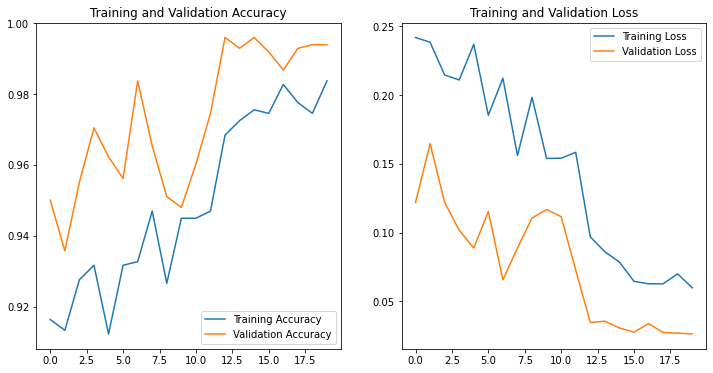

In [27]:
#showing results and model accuracy 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=20
epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
